In [1]:
from tensorflow.keras import models, Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dense, InputLayer, BatchNormalization, Input, ReLU, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1,L2,l1_l2
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import save_model, load_model
import pickle
from sklearn.manifold import TSNE

In [2]:
seed = 909

In [3]:
#%run autoencoder-models.ipynb

## Data imports

In [11]:
image_datagen = ImageDataGenerator(rescale = 1/255)

In [4]:

mask_datagen = ImageDataGenerator(rescale = 1/255)

train_imagegen = image_datagen.flow_from_directory('scan+mask/train/scan', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
train_maskgen = mask_datagen.flow_from_directory('scan+mask/train/mask', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
val_imagegen = image_datagen.flow_from_directory('scan+mask/val/scan', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
val_maskgen = mask_datagen.flow_from_directory('scan+mask/val/mask', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
test_imagegen = image_datagen.flow_from_directory('scan+mask/test/scan', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
test_maskgen = mask_datagen.flow_from_directory('scan+mask/test/mask', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)

Found 1838 images belonging to 1 classes.
Found 1838 images belonging to 1 classes.
Found 613 images belonging to 1 classes.
Found 613 images belonging to 1 classes.
Found 613 images belonging to 1 classes.
Found 613 images belonging to 1 classes.


## Quick look

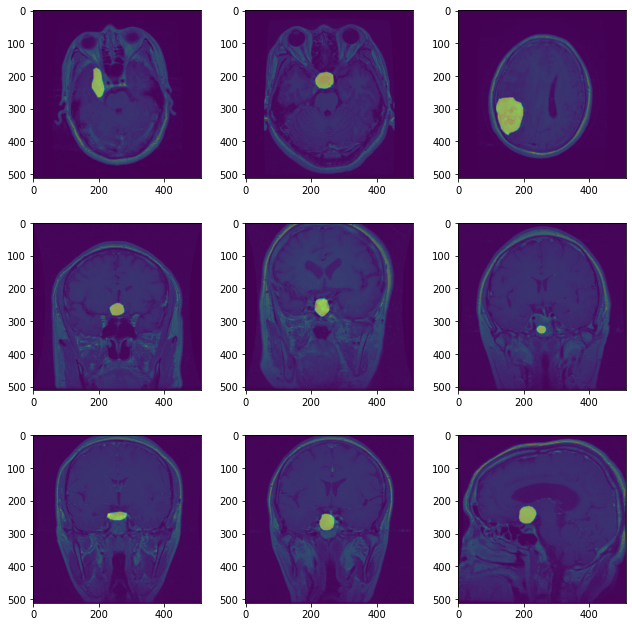

In [5]:
f,ax = plt.subplots(3,3, figsize=(9,9))
plt.tight_layout()
for i,axs in enumerate(ax.ravel()):
    axs.imshow(train_imagegen[i][1], alpha=1)
    axs.imshow(train_maskgen[i][1], alpha=0.5)

plt.show()

## Losses

In [5]:
def mean_iou(y_true, y_pred):
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32') # .5 is the threshold
    ones = K.sum(K.flatten(y_pred * y_true)) / K.sum(K.flatten(y_true))
    y_pred = K.cast(K.equal(y_pred, 0), dtype='float32')
    y_true = K.cast(K.equal(y_true, 0), dtype='float32')
    zeros = K.sum(K.flatten(y_pred * y_true)) / K.sum(K.flatten(y_true))
    return (ones + zeros)/2.0

In [6]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [7]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

In [8]:
def focal_dice_crosse(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred) + dice_coef_loss(y_true, y_pred) + focal_loss()(y_true, y_pred)

## Model

In [35]:
# model-2 inspired by u-net

def convolution(inputs, filters = 32):
    conv1 = Conv2D(filters, kernel_size=(3,3), padding="same", strides=(1,1))(inputs)
    #batch_norm1 = BatchNormalization()(conv1)
    relu1 = ReLU()(conv1)
    
    conv2 = Conv2D(filters, kernel_size=(3,3), padding="same", strides=(1,1))(relu1)
    #batch_norm2 = BatchNormalization()(conv2)
    relu2 = ReLU()(conv2)
    
    return relu2
    
def encoder(inputs, filters = 32):
    cv = convolution(inputs, filters)
    maxpool = MaxPooling2D(pool_size=(4,4))(cv)
    return (cv,maxpool)

def decoder(inputs, skips , filters = 32):
    cv1 = Conv2DTranspose(filters, kernel_size=(3,3), padding="same", strides=(4,4))(inputs)
    concate = Concatenate()([cv1, skips])
    cv2 = convolution(concate, filters)
    return cv2

def U_Net(image_size):
    input1 = Input(image_size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 16)
    skip2, encoder_2 = encoder(encoder_1, 16*2)
    skip3, encoder_3 = encoder(encoder_2, 16*4)
    skip4, encoder_4 = encoder(encoder_3, 16*8)
    
    # Preparing the next block
    conv_block = convolution(encoder_4, 16*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 16*8)
    decoder_2 = decoder(decoder_1, skip3, 16*4)
    decoder_3 = decoder(decoder_2, skip2, 16*2)
    decoder_4 = decoder(decoder_3, skip1, 16)
    
    out = Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model

model = U_Net((512,512,1))
model.compile(optimizer = Adam(learning_rate=1e-3), loss=focal_dice_crosse, metrics = [mean_iou, 'accuracy'])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 512, 512, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        re_lu[0][0]                      
______________________________________________________________________________________________

## Training

In [12]:
model.fit(zip(train_imagegen,train_maskgen), epochs=100, steps_per_epoch = 114, 
            validation_data= zip(val_imagegen, val_maskgen), validation_steps=38,validation_batch_size=16, workers=-1,
            use_multiprocessing=True)

Epoch 1/100
114/114 [==============================] - 88s 683ms/step - loss: 1.1059 - mean_iou: 0.5010 - accuracy: 0.9740 - val_loss: 0.9581 - val_mean_iou: 0.5000 - val_accuracy: 0.9808
Epoch 2/100
114/114 [==============================] - 82s 685ms/step - loss: 0.9614 - mean_iou: 0.5044 - accuracy: 0.9796 - val_loss: 0.9724 - val_mean_iou: 0.5000 - val_accuracy: 0.9807
Epoch 3/100
114/114 [==============================] - 80s 701ms/step - loss: 0.9481 - mean_iou: 0.5147 - accuracy: 0.9782 - val_loss: 0.9807 - val_mean_iou: 0.5000 - val_accuracy: 0.9811
Epoch 4/100
114/114 [==============================] - 81s 714ms/step - loss: 0.9395 - mean_iou: 0.5303 - accuracy: 0.9782 - val_loss: 0.9659 - val_mean_iou: 0.6723 - val_accuracy: 0.9566
Epoch 5/100
114/114 [==============================] - 83s 730ms/step - loss: 0.9082 - mean_iou: 0.6256 - accuracy: 0.9766 - val_loss: 0.8920 - val_mean_iou: 0.6440 - val_accuracy: 0.9779
Epoch 6/100
114/114 [==============================] - 84s 7

114/114 [==============================] - 84s 734ms/step - loss: 0.1434 - mean_iou: 0.9357 - accuracy: 0.9932 - val_loss: 0.4147 - val_mean_iou: 0.8239 - val_accuracy: 0.9865
Epoch 88/100
114/114 [==============================] - 84s 738ms/step - loss: 0.1404 - mean_iou: 0.9370 - accuracy: 0.9933 - val_loss: 0.4780 - val_mean_iou: 0.7706 - val_accuracy: 0.9862
Epoch 89/100
114/114 [==============================] - 84s 738ms/step - loss: 0.1427 - mean_iou: 0.9356 - accuracy: 0.9933 - val_loss: 0.4459 - val_mean_iou: 0.8007 - val_accuracy: 0.9864
Epoch 90/100
114/114 [==============================] - 84s 736ms/step - loss: 0.1467 - mean_iou: 0.9340 - accuracy: 0.9931 - val_loss: 0.4129 - val_mean_iou: 0.8236 - val_accuracy: 0.9870
Epoch 91/100
114/114 [==============================] - 84s 738ms/step - loss: 0.1387 - mean_iou: 0.9387 - accuracy: 0.9934 - val_loss: 0.4012 - val_mean_iou: 0.8272 - val_accuracy: 0.9868
Epoch 92/100
114/114 [==============================] - 83s 731ms/st

In [12]:
history = model.fit(zip(train_imagegen,train_maskgen), epochs=100, steps_per_epoch = 114, 
            validation_data= zip(val_imagegen, val_maskgen), validation_steps=38,validation_batch_size=16, workers=-1,
            use_multiprocessing=True)
hist = history.history

Epoch 1/100
114/114 [==============================] - 85s 673ms/step - loss: 1.0647 - mean_iou: 0.5000 - accuracy: 0.9811 - val_loss: 0.9740 - val_mean_iou: 0.5000 - val_accuracy: 0.9808
Epoch 2/100
114/114 [==============================] - 85s 707ms/step - loss: 0.9838 - mean_iou: 0.5263 - accuracy: 0.9751 - val_loss: 0.9550 - val_mean_iou: 0.5519 - val_accuracy: 0.9720
Epoch 3/100
114/114 [==============================] - 82s 718ms/step - loss: 0.9687 - mean_iou: 0.5404 - accuracy: 0.9766 - val_loss: 0.9350 - val_mean_iou: 0.5690 - val_accuracy: 0.9803
Epoch 4/100
114/114 [==============================] - 82s 722ms/step - loss: 0.9221 - mean_iou: 0.6063 - accuracy: 0.9748 - val_loss: 0.8946 - val_mean_iou: 0.6566 - val_accuracy: 0.9752
Epoch 5/100
114/114 [==============================] - 83s 726ms/step - loss: 0.8700 - mean_iou: 0.6442 - accuracy: 0.9767 - val_loss: 0.8579 - val_mean_iou: 0.6166 - val_accuracy: 0.9802
Epoch 6/100
114/114 [==============================] - 83s 7

114/114 [==============================] - 83s 726ms/step - loss: 0.1451 - mean_iou: 0.9339 - accuracy: 0.9932 - val_loss: 0.3790 - val_mean_iou: 0.8333 - val_accuracy: 0.9877
Epoch 88/100
114/114 [==============================] - 83s 726ms/step - loss: 0.1482 - mean_iou: 0.9349 - accuracy: 0.9931 - val_loss: 0.3852 - val_mean_iou: 0.8207 - val_accuracy: 0.9878
Epoch 89/100
114/114 [==============================] - 84s 737ms/step - loss: 0.1446 - mean_iou: 0.9348 - accuracy: 0.9932 - val_loss: 0.4005 - val_mean_iou: 0.8104 - val_accuracy: 0.9877
Epoch 90/100
114/114 [==============================] - 84s 738ms/step - loss: 0.1427 - mean_iou: 0.9363 - accuracy: 0.9932 - val_loss: 0.3545 - val_mean_iou: 0.8397 - val_accuracy: 0.9883
Epoch 91/100
114/114 [==============================] - 84s 736ms/step - loss: 0.1339 - mean_iou: 0.9394 - accuracy: 0.9935 - val_loss: 0.4051 - val_mean_iou: 0.8208 - val_accuracy: 0.9871
Epoch 92/100
114/114 [==============================] - 83s 730ms/st

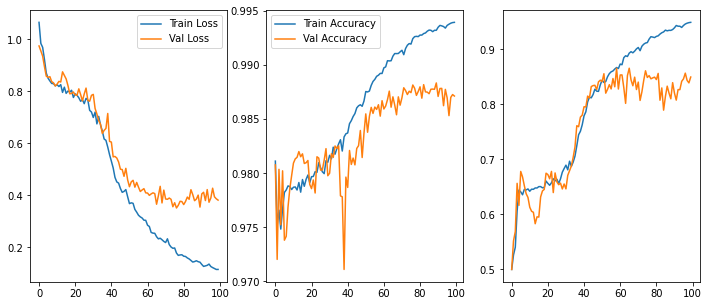

In [13]:
f,ax = plt.subplots(1,3, figsize=(12,5))
ax[0].plot(hist['loss'], label="Train Loss")
ax[0].plot(hist['val_loss'], label="Val Loss")

ax[1].plot(hist['accuracy'], label="Train Accuracy")
ax[1].plot(hist['val_accuracy'], label="Val Accuracy")

ax[2].plot(hist['mean_iou'], label="Train Mean Itersection Union")
ax[2].plot(hist['val_mean_iou'], label="Val Mean Itersection Union")


ax[0].legend()
ax[1].legend()
plt.show()

In [9]:
model = load_model('./models/model2_v1.h5', custom_objects={'focal_dice_crosse':focal_dice_crosse, 'mean_iou':mean_iou})
with open("./history/model2_v2_hist","rb") as f:
    hist = pickle.load(f)

In [40]:
save_model(model, './models/model2_v2.h5')
with open("./history/model2_v2_hist","wb") as f:
    pickle.dump(history.history, f)

## Visualizing validation data

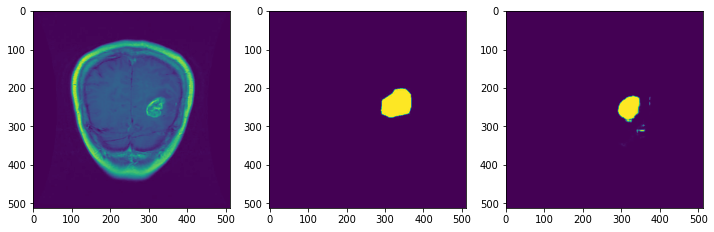

In [70]:
batch = random.randint(0,38)
img = random.randint(0,16)

f,ax = plt.subplots(1,3, figsize=(12,12))
ax[0].imshow(val_imagegen[batch][img])
ax[1].imshow(val_maskgen[batch][img])
ax[2].imshow(model.predict(val_imagegen[batch][img].reshape(1,512,512,1)).reshape(512,512))
plt.show()

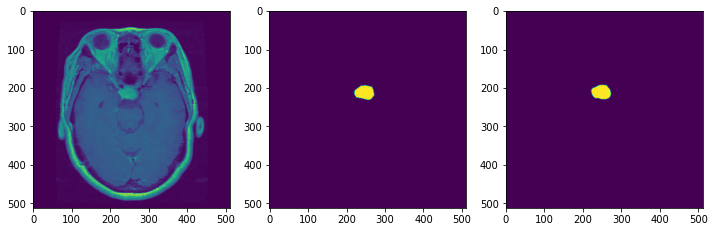

In [22]:
batch = random.randint(0,10)
img = random.randint(0,16)

f,ax = plt.subplots(1,3, figsize=(12,12))
ax[0].imshow(test_imagegen[batch][img])
ax[1].imshow(test_maskgen[batch][img])
ax[2].imshow(model.predict(test_imagegen[batch][img].reshape(1,512,512,1)).reshape(512,512))
plt.show()

## Inference

### TSNE

In [79]:
class_imagegen = image_datagen.flow_from_directory('for-tsne/', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode='categorical',
                                  batch_size=1500, seed=seed, shuffle=True)

Found 3064 images belonging to 3 classes.


In [80]:
encoder_input = Input(shape=model.layers[0].input_shape[0][1:])
encoder_model = encoder_input
for layer in model.layers[1:25]:
    encoder_model = layer(encoder_model)

encoder_model = Model(inputs = encoder_input, outputs = encoder_model)

In [81]:
tsne_out = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(K.batch_flatten(encoder_model.predict(class_imagegen[0][0])))

D:\Programs\Anaconda\envs\tf2.8\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


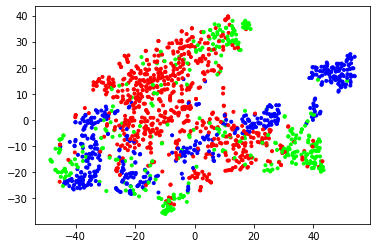

In [82]:
plt.scatter(tsne_out[:,0], tsne_out[:,1], c=class_imagegen[0][1], marker='.')
plt.show()

### Other techniques

## Classification based on latent layer

In [24]:
train_imagegen = image_datagen.flow_from_directory('classification/train/', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode='categorical',
                                  batch_size=16, seed=seed, shuffle=True)
val_imagegen = image_datagen.flow_from_directory('classification/validation/', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode='categorical',
                                  batch_size=16, seed=seed, shuffle=True)
test_imagegen = image_datagen.flow_from_directory('classification/test/', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode='categorical',
                                  batch_size=16, seed=seed, shuffle=True)

Found 1839 images belonging to 3 classes.
Found 613 images belonging to 3 classes.
Found 612 images belonging to 3 classes.


In [25]:
classification_input = Input(shape=model.layers[0].input_shape[0][1:])
classification_model = classification_input
for layer in model.layers[1:25]:
    layer.trainable = False
    classification_model = layer(classification_model)

flat = Flatten()(classification_model)
dense1 = Dense(512, activation='relu')(flat)
dense2 = Dense(64, activation='relu')(dense1)
final = Dense(3, activation='softmax')(dense2)


classification_model = Model(inputs = classification_input, outputs = final)
classification_model.compile(optimizer = Adam(), loss=CategoricalCrossentropy(), metrics =['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [26]:
classification_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 16)      160       
_________________________________________________________________
re_lu (ReLU)                 (None, 512, 512, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 16)      2320      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 512, 512, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      4640

In [27]:
classifi_hist = classification_model.fit(train_imagegen, epochs=7, steps_per_epoch = 114, 
            validation_data= val_imagegen, validation_steps=38,validation_batch_size=16, workers=-1,
            use_multiprocessing=True)

Epoch 1/7
114/114 [==============================] - 10s 78ms/step - loss: 0.5993 - accuracy: 0.7663 - recall_3: 0.7016 - precision_3: 0.8199 - val_loss: 0.5238 - val_accuracy: 0.8043 - val_recall_3: 0.7714 - val_precision_3: 0.8228
Epoch 2/7
114/114 [==============================] - 9s 77ms/step - loss: 0.4102 - accuracy: 0.8453 - recall_3: 0.8256 - precision_3: 0.8649 - val_loss: 0.4367 - val_accuracy: 0.8273 - val_recall_3: 0.7977 - val_precision_3: 0.8406
Epoch 3/7
114/114 [==============================] - 9s 76ms/step - loss: 0.3204 - accuracy: 0.8826 - recall_3: 0.8618 - precision_3: 0.8972 - val_loss: 0.4266 - val_accuracy: 0.8355 - val_recall_3: 0.8125 - val_precision_3: 0.8473
Epoch 4/7
114/114 [==============================] - 9s 77ms/step - loss: 0.3052 - accuracy: 0.8738 - recall_3: 0.8623 - precision_3: 0.8856 - val_loss: 0.4618 - val_accuracy: 0.8224 - val_recall_3: 0.8076 - val_precision_3: 0.8408
Epoch 5/7
114/114 [==============================] - 9s 77ms/step - los

In [28]:
classification_model.evaluate(test_imagegen)

39/39 [==============================] - 2s 46ms/step - loss: 0.4672 - accuracy: 0.8399 - recall_3: 0.8252 - precision_3: 0.8530


[0.4672222137451172,
 0.8398692607879639,
 0.8251634240150452,
 0.8530405163764954]

In [32]:
save_model(classification_model, './models/model2_v2_classification.h5')
with open("./history/model2_v2_classification_hist","wb") as f:
    pickle.dump(classifi_hist.history, f)

In [33]:
with open("./history/model2_v2_classification_hist","rb") as f:
    t = pickle.load(f)

## Final loss, accuracy, thoughts